# Modeling technical noise

## generate example data 

In [1]:
import numpy as np
import pandas as pd

num_genes = 200
num_samples = 100
np.random.seed(42)

gene_ranges = [(i * 5, i * 5 + 10 + np.random.randint(0, 10)) for i in range(num_genes)]

gene_expression_values = np.vstack(
    [
        np.random.uniform(low=min_val, high=max_val, size=num_samples)
        for min_val, max_val in gene_ranges
    ]
).T

gene_names = [f"gene{i+1}" for i in range(num_genes)]
sample_indices = [f"cell{i+1}" for i in range(num_samples)]
df = pd.DataFrame(gene_expression_values, columns=gene_names, index=sample_indices)

df.head()

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
cell1,6.381191,8.304127,23.790471,24.534552,29.876219,42.740145,39.342863,43.551294,41.160245,46.283791,...,952.860164,963.380070,974.907159,971.172246,982.465694,988.246077,984.141011,996.739685,990.471251,999.769444
cell2,13.062910,8.838778,23.950871,18.325091,35.687404,25.143153,31.717536,42.697407,54.230343,49.709186,...,953.953103,966.082125,962.020236,970.030503,977.191328,983.320933,984.911735,996.855795,993.089009,996.737113
cell3,12.773522,9.193160,20.640974,20.603121,29.729406,29.281323,32.454535,42.952191,47.432288,52.315269,...,951.685275,955.702999,967.054295,973.529496,973.918620,990.043211,986.096438,994.986260,1000.680118,1009.249139
cell4,2.411481,16.032707,23.947256,21.688008,30.186309,31.941780,38.568769,47.245700,55.563733,55.251805,...,953.232677,960.894358,964.619746,972.086899,972.056499,985.032308,980.055466,994.140393,996.074152,1000.081312
cell5,8.131180,6.776077,21.075241,16.160479,28.877050,34.268386,35.927778,36.647704,52.266059,45.046849,...,960.676793,958.373071,960.253792,973.895551,977.319702,979.090962,986.889156,986.494385,992.950985,1005.698235


## convert the data into a tensor

In [2]:
import torch

clean_samples_tensor = torch.tensor(df.values, dtype=torch.float)
clean_samples_tensor

tensor([[   6.3812,    8.3041,   23.7905,  ...,  996.7397,  990.4713,
          999.7695],
        [  13.0629,    8.8388,   23.9509,  ...,  996.8558,  993.0890,
          996.7371],
        [  12.7735,    9.1932,   20.6410,  ...,  994.9863, 1000.6801,
         1009.2491],
        ...,
        [   3.3427,   13.8032,   23.0423,  ...,  987.3571,  992.1442,
         1008.6753],
        [  10.7383,   12.4538,   23.9874,  ...,  993.9875,  997.8079,
         1008.2759],
        [   5.7383,    6.6705,   22.6516,  ...,  986.0485,  990.8264,
          999.2260]])

## apply biological noise process

In [3]:
import pyro.distributions as dist


def apply_biological_noise_process(tensor, mean=0.0, std=1.0):
    noise = dist.LogNormal(mean, std).sample(tensor.size())
    return tensor + noise


bio_noise_mean = 0.0
bio_noise_std = 1.0

bio_noise_tensor = apply_biological_noise_process(clean_samples_tensor, bio_noise_std)
bio_noise_df = pd.DataFrame(bio_noise_tensor.numpy(), columns=df.columns)

display(bio_noise_tensor)
display(bio_noise_df)

tensor([[   7.0151,   11.2984,   45.1310,  ...,  999.0103,  991.0764,
         1015.7690],
        [  13.4551,   15.9888,   26.2547,  ...,  998.9598,  995.7579,
          998.3433],
        [  24.9868,   10.4395,   23.5280,  ..., 1002.6477, 1001.9692,
         1012.1912],
        ...,
        [  11.9075,   16.1487,   25.0770,  ...,  990.3958,  994.4012,
         1011.2889],
        [  14.3077,   14.1968,   28.0873,  ...,  998.6326,  999.1442,
         1009.8995],
        [   9.0388,   38.0312,   25.4481,  ...,  987.9937, 1020.5305,
         1003.4754]])

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
0,7.015111,11.298352,45.130997,25.082016,30.481064,45.739140,43.643417,48.680424,41.597275,47.800167,...,955.436768,976.196899,979.607239,973.834412,984.404724,989.546997,987.233521,999.010254,991.076416,1015.768982
1,13.455115,15.988836,26.254681,34.440071,44.059864,25.891760,38.882309,43.627705,56.693970,79.489006,...,956.735229,968.298767,967.375183,978.144470,982.061951,987.175171,986.457153,998.959839,995.757874,998.343262
2,24.986767,10.439509,23.527975,24.455582,38.593121,29.885164,69.959511,49.221428,48.548031,54.548023,...,958.060608,956.385498,969.696655,976.469971,975.129944,993.888000,987.842224,1002.647705,1001.969238,1012.191162
3,4.264246,18.579643,29.322374,22.329199,33.505409,34.004425,38.686596,55.551857,57.245136,57.121506,...,959.887451,963.183655,990.278687,974.006714,972.761658,989.833069,981.009766,994.907349,1003.065369,1001.771240
4,45.014389,6.997225,28.303482,22.207909,35.190018,35.825092,38.598827,39.070179,54.844212,45.846676,...,962.763611,960.294128,961.720825,980.043152,978.236938,981.089966,996.586060,991.261047,998.723145,1007.021057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16.320934,16.951023,25.513338,22.665030,38.230522,56.350842,42.228050,40.935593,41.588783,66.256577,...,961.134705,971.403992,976.029724,975.714050,988.555115,996.063538,988.750977,996.769592,1001.859009,1006.745850
96,3.640522,22.512091,32.209969,26.438259,30.865269,40.792671,41.187183,51.824345,49.867687,51.982010,...,968.207520,964.320923,963.489746,975.992737,976.015991,980.978271,988.698547,999.301697,1002.176636,1008.708435
97,11.907541,16.148655,25.077030,30.039545,37.869358,44.252853,35.262993,39.064068,52.104893,59.997414,...,963.380798,956.794495,982.807434,970.050293,983.901184,983.979370,983.439941,990.395813,994.401245,1011.288879
98,14.307689,14.196836,28.087334,29.856800,29.337599,40.584621,38.969006,39.438900,52.160172,46.589317,...,963.475098,964.352051,966.852478,977.152527,978.576233,981.380310,989.878784,998.632568,999.144165,1009.899536


## apply outlier process

In [4]:
def apply_outlier_process(tensor, pi, mu, sigma):
    binary_indicators = dist.Bernoulli(pi).sample(tensor.size())
    scale_factors = dist.LogNormal(mu, sigma).sample(tensor.size())
    updated_tensor = tensor * scale_factors * binary_indicators + (1 - binary_indicators) * tensor
    return updated_tensor


outlier_pi = 0.2
outlier_mu = 0.0
outlier_sigma = 1.0

outliers_tensor = apply_outlier_process(bio_noise_tensor, outlier_pi, outlier_mu, outlier_sigma)
outliers_df = pd.DataFrame(outliers_tensor.numpy(), columns=df.columns)

display(outliers_tensor)
display(outliers_df)

tensor([[   7.0151,   11.2984,   45.1310,  ...,  123.9759, 2894.1316,
         1015.7690],
        [   6.1193,   15.9888,   26.2547,  ...,  998.9598,  995.7579,
         1210.1682],
        [  24.9868,   10.4395,   23.5280,  ..., 1002.6477, 1001.9692,
         1012.1912],
        ...,
        [  11.9075,   32.1420,   25.0770,  ...,  990.3958,  994.4012,
         1011.2889],
        [  14.3077,   14.1968,   28.0873,  ...,  998.6326,  999.1442,
          305.0020],
        [   9.0388,  114.1117,   25.4481,  ...,  987.9937, 1020.5305,
         1003.4754]])

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
0,7.015111,11.298352,45.130997,25.082016,30.481064,73.481400,36.856178,48.680424,41.597275,47.800167,...,955.436768,976.196899,979.607239,973.834412,984.404724,989.546997,987.233521,123.975876,2894.131592,1015.768982
1,6.119299,15.988836,26.254681,34.440071,44.059864,25.891760,99.161911,26.711170,56.693970,79.489006,...,956.735229,968.298767,967.375183,978.144470,982.061951,987.175171,986.457153,998.959839,995.757874,1210.168213
2,24.986767,10.439509,23.527975,24.455582,38.593121,29.885164,69.959511,73.879761,48.548031,54.548023,...,5399.595215,956.385498,8033.541992,1984.801147,975.129944,993.888000,1156.585815,1002.647705,1001.969238,1012.191162
3,4.264246,18.579643,18.068707,95.963516,29.621180,1.624616,38.686596,55.551857,57.245136,57.121506,...,959.887451,963.183655,990.278687,625.737488,588.929382,623.558167,981.009766,994.907349,1003.065369,1001.771240
4,45.014389,6.997225,28.303482,22.207909,6.608774,35.825092,38.598827,39.070179,54.844212,45.846676,...,266.805725,960.294128,1053.479004,980.043152,978.236938,981.089966,996.586060,991.261047,998.723145,1007.021057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16.320934,16.951023,25.513338,22.665030,163.337326,23.349268,33.865932,40.935593,41.588783,66.256577,...,961.134705,971.403992,901.916870,975.714050,2728.657227,996.063538,988.750977,317.958313,1001.859009,1006.745850
96,3.640522,22.512091,32.209969,60.250523,30.865269,40.792671,41.187183,51.824345,63.420586,51.982010,...,968.207520,964.320923,963.489746,1600.142578,914.075012,980.978271,776.242432,999.301697,1002.176636,1008.708435
97,11.907541,32.142040,25.077030,20.775328,37.869358,44.252853,35.262993,39.064068,52.104893,59.997414,...,963.380798,956.794495,458.155731,4319.041504,53.242798,504.386841,11033.001953,990.395813,994.401245,1011.288879
98,14.307689,14.196836,28.087334,29.856800,29.337599,68.919670,38.969006,39.438900,160.550842,106.049683,...,963.475098,964.352051,966.852478,977.152527,978.576233,981.380310,989.878784,998.632568,999.144165,305.002045


## apply library size process

In [5]:
def apply_library_size_process(tensor, mu, sigma):
    row_sums = tensor.sum(dim=1, keepdim=True)
    L = dist.LogNormal(mu, sigma).sample([tensor.size(0), 1])
    scaled_tensor = (L * tensor) / row_sums
    return scaled_tensor


library_mu = 10.0
library_sigma = 1.0

library_size_tensor = apply_library_size_process(outliers_tensor, library_mu, library_sigma)
library_size_df = pd.DataFrame(library_size_tensor.numpy(), columns=df.columns)

display(library_size_tensor)
display(library_size_df)

tensor([[2.7644e+00, 4.4523e+00, 1.7785e+01,  ..., 4.8855e+01, 1.1405e+03,
         4.0028e+02],
        [8.1027e-01, 2.1171e+00, 3.4764e+00,  ..., 1.3227e+02, 1.3185e+02,
         1.6024e+02],
        [3.8511e+00, 1.6090e+00, 3.6262e+00,  ..., 1.5453e+02, 1.5443e+02,
         1.5600e+02],
        ...,
        [3.6163e+00, 9.7616e+00, 7.6160e+00,  ..., 3.0079e+02, 3.0200e+02,
         3.0713e+02],
        [2.9309e+00, 2.9081e+00, 5.7535e+00,  ..., 2.0456e+02, 2.0467e+02,
         6.2478e+01],
        [1.1396e+01, 1.4387e+02, 3.2085e+01,  ..., 1.2456e+03, 1.2867e+03,
         1.2652e+03]])

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
0,2.764439,4.452332,17.784735,9.884048,12.011647,28.956755,14.523883,19.183453,16.392204,18.836571,...,376.508179,384.689087,386.032990,383.758118,387.923553,389.949951,389.038269,48.855072,1140.488037,400.283234
1,0.810266,2.117107,3.476424,4.560264,5.834036,3.428369,13.130186,3.536868,7.506938,10.525266,...,126.682831,128.213974,128.091690,129.517654,130.036377,130.713440,130.618362,132.273865,131.849869,160.240295
2,3.851075,1.608985,3.626239,3.769206,5.948148,4.606039,10.782481,11.386687,7.482445,8.407191,...,832.210388,147.402512,1238.166260,305.906647,150.291489,153.182571,178.258301,154.532654,154.428085,156.003555
3,2.618397,11.408555,11.094822,58.924973,18.188446,0.997571,23.754930,34.110794,35.150528,35.074615,...,589.404663,591.428650,608.065979,384.224854,361.623383,382.886658,602.374512,610.908081,615.917419,615.122803
4,6.730494,1.046216,4.231901,3.320498,0.988135,5.356522,5.771248,5.841723,8.200236,6.854937,...,39.892452,143.581955,157.514847,146.534805,146.264740,146.691330,149.008286,148.212097,149.327805,150.568512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.001610,4.156097,6.255428,5.557073,40.047482,5.724836,8.303340,10.036697,10.196849,16.244965,...,235.653580,238.171432,221.134384,239.228165,669.019470,244.217514,242.424606,77.957863,245.638474,246.836639
96,0.143970,0.890277,1.273796,2.382705,1.220617,1.613213,1.628814,2.049478,2.508070,2.055713,...,38.289345,38.135643,38.102772,63.280243,36.148586,38.794384,30.697769,39.519016,39.632706,39.891018
97,3.616350,9.761618,7.615956,6.309519,11.501019,13.439702,10.709458,11.863854,15.824387,18.221365,...,292.581146,290.580872,139.143036,1311.703735,16.169970,153.183533,3350.750000,300.785675,302.002136,307.130951
98,2.930854,2.908147,5.753541,6.116007,6.009652,14.117829,7.982594,8.078850,32.887989,21.723715,...,197.362762,197.542404,198.054596,200.164520,200.456146,201.030548,202.771423,204.564590,204.669373,62.478050


## apply dropout process

In [6]:
def apply_dropout_process(tensor, k, q):
    Y = torch.log(tensor + 1)
    y_0 = torch.quantile(Y, q)
    pi = 1 / (1 + torch.exp(-k * (Y - y_0)))
    binary_indicators = dist.Bernoulli(pi).sample()
    updated_tensor = binary_indicators * tensor
    return updated_tensor


dropout_k = 1.0  # Logistic function parameter
dropout_q = 0.5  # Percentile for y_0 (median)

dropout_tensor = apply_dropout_process(library_size_tensor, dropout_k, dropout_q)
dropout_df = pd.DataFrame(dropout_tensor.numpy(), columns=df.columns)

display(dropout_tensor)
display(dropout_df)

tensor([[   0.0000,    0.0000,    0.0000,  ...,   48.8551, 1140.4880,
          400.2832],
        [   0.0000,    0.0000,    0.0000,  ...,  132.2739,    0.0000,
          160.2403],
        [   0.0000,    0.0000,    0.0000,  ...,  154.5327,  154.4281,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,  302.0021,
          307.1310],
        [   0.0000,    0.0000,    0.0000,  ...,  204.5646,  204.6694,
            0.0000],
        [   0.0000,  143.8702,   32.0846,  ..., 1245.6469, 1286.6687,
         1265.1659]])

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,16.392204,0.000000,...,376.508179,384.689087,386.032990,383.758118,387.923553,389.949951,389.038269,48.855072,1140.488037,400.283234
1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,128.213974,0.000000,129.517654,130.036377,130.713440,130.618362,132.273865,0.000000,160.240295
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,832.210388,147.402512,1238.166260,305.906647,0.000000,153.182571,178.258301,154.532654,154.428085,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,35.150528,0.000000,...,589.404663,591.428650,608.065979,0.000000,0.000000,382.886658,0.000000,610.908081,615.917419,615.122803
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,8.200236,0.000000,...,0.000000,143.581955,0.000000,0.000000,146.264740,0.000000,0.000000,148.212097,149.327805,150.568512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.000000,0.000000,5.557073,40.047482,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,221.134384,239.228165,669.019470,244.217514,0.000000,77.957863,245.638474,246.836639
96,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,63.280243,36.148586,38.794384,30.697769,0.000000,0.000000,0.000000
97,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,18.221365,...,292.581146,290.580872,0.000000,1311.703735,0.000000,0.000000,0.000000,0.000000,302.002136,307.130951
98,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,21.723715,...,197.362762,0.000000,198.054596,200.164520,200.456146,201.030548,202.771423,204.564590,204.669373,0.000000


## apply UMI count process

In [7]:
def apply_umi_count_process(tensor):
    umi_counts = dist.Poisson(tensor).sample()
    return umi_counts


umi_count_tensor = apply_umi_count_process(dropout_tensor)
umi_count_df = pd.DataFrame(umi_count_tensor.numpy(), columns=df.columns)

display(umi_count_tensor)
display(umi_count_df)

tensor([[   0.,    0.,    0.,  ...,   46., 1115.,  427.],
        [   0.,    0.,    0.,  ...,  140.,    0.,  172.],
        [   0.,    0.,    0.,  ...,  157.,  180.,    0.],
        ...,
        [   0.,    0.,    0.,  ...,    0.,  330.,  307.],
        [   0.,    0.,    0.,  ...,  196.,  209.,    0.],
        [   0.,  132.,   27.,  ..., 1219., 1321., 1225.]])

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,...,341.0,379.0,376.0,365.0,387.0,412.0,404.0,46.0,1115.0,427.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,110.0,0.0,121.0,136.0,109.0,117.0,140.0,0.0,172.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,882.0,171.0,1223.0,332.0,0.0,132.0,183.0,157.0,180.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,...,550.0,575.0,606.0,0.0,0.0,352.0,0.0,618.0,611.0,661.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,163.0,0.0,0.0,164.0,0.0,0.0,155.0,135.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,4.0,41.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,197.0,241.0,691.0,241.0,0.0,75.0,227.0,244.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,62.0,42.0,37.0,41.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,...,281.0,266.0,0.0,1421.0,0.0,0.0,0.0,0.0,330.0,307.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,191.0,0.0,201.0,196.0,185.0,213.0,213.0,196.0,209.0,0.0


## visualization
before vs after applying the technical noise

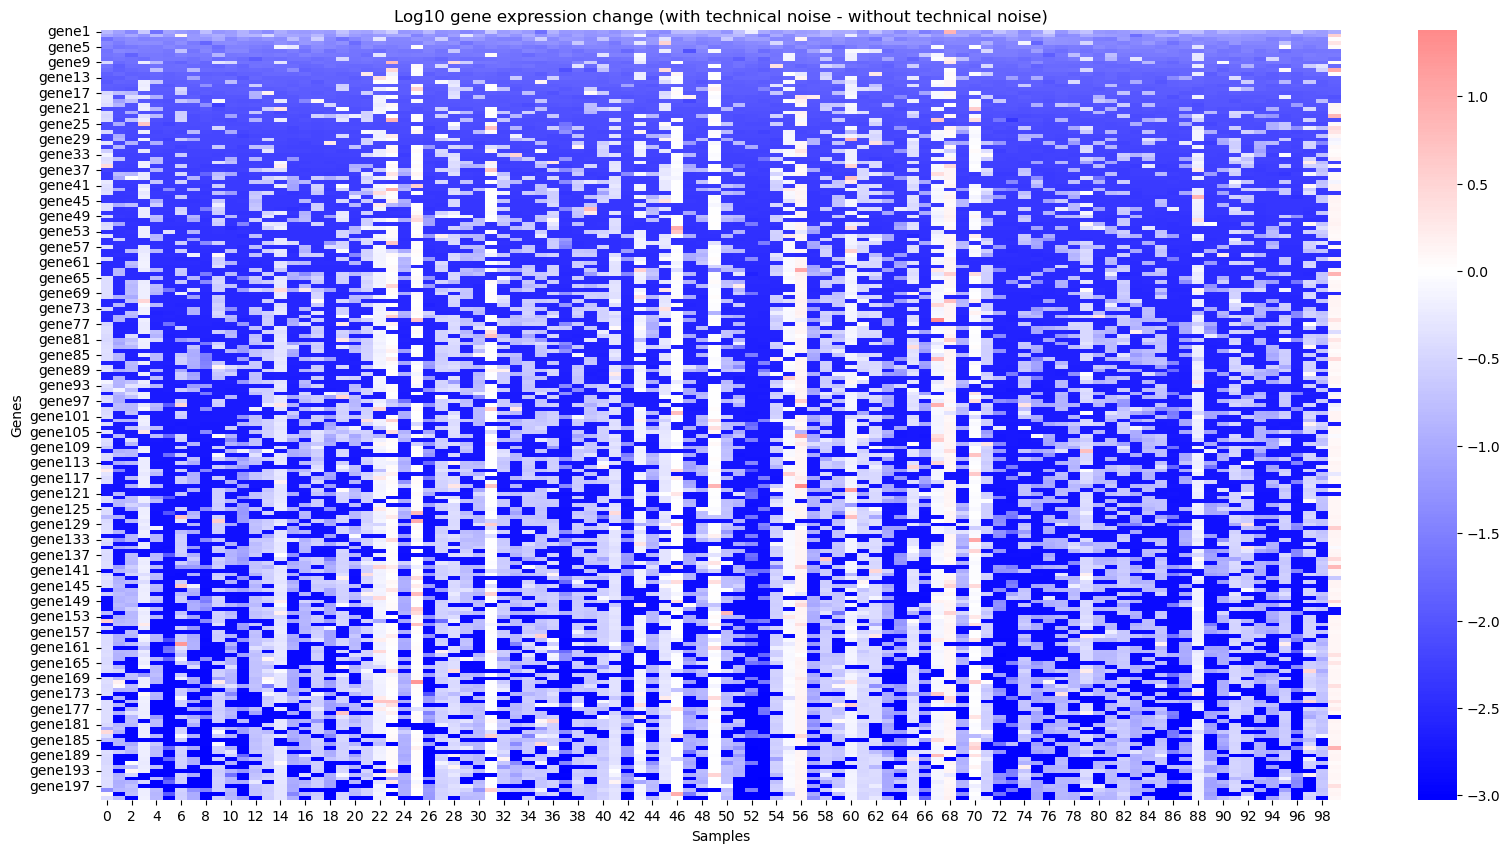

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df1 = bio_noise_df
df2 = umi_count_df
title = "Log10 gene expression change (with technical noise - without technical noise)"

df1_safe = df1.replace(0, 1)
df2_safe = df2.replace(0, 1)
log10_change = np.log10(df2_safe / df1_safe)

plt.figure(figsize=(20, 10))
sns.heatmap(log10_change.T, cmap="bwr", center=0, cbar=True)
plt.title(title)
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()